In [1]:
import os
import numpy as np
import pandas as pd
import random
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import exposure

2024-09-28 06:07:17.911498: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 06:07:17.988904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 06:07:18.019846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 06:07:18.029630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 06:07:18.088307: I tensorflow/core/platform/cpu_feature_guar

In [3]:
class DataGenerator(Sequence):
    def __init__(self, directory, batch_size=8, file_sample_ratio=0.05, sample_ratio=0.05, img_size=(128, 128), shuffle=True, return_names=False):
        super().__init__()
        self.directory = directory
        self.batch_size = batch_size
        self.file_sample_ratio = file_sample_ratio
        self.sample_ratio = sample_ratio
        self.img_size = img_size
        self.shuffle = shuffle
        self.return_names = return_names
        self.npz_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npz')]

        # Sample a subset of files to manage large datasets
        num_files = len(self.npz_files)
        self.sampled_files = random.sample(self.npz_files, int(self.file_sample_ratio * num_files))
        self.filenames = [self.format_filename(os.path.basename(f)) for f in self.sampled_files]

        if self.shuffle:
            random.shuffle(self.sampled_files)

        self.on_epoch_end()

    def format_filename(self, filename):
        # Remove the file extension
        name_without_extension = os.path.splitext(filename)[0]
        # Split by underscores and take the first two parts
        parts = name_without_extension.split('_')[:2]
        # Join with a space
        return ' '.join(parts)

    def __len__(self):
        return int(np.floor(len(self.sampled_files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.sampled_files[index * self.batch_size:(index + 1) * self.batch_size]

        images, image_names = [], []
        for npz_file in batch_files:
            data = np.load(npz_file)
            color_images = data['colorImages']

            num_frames = color_images.shape[-1]
            sampled_indices = random.sample(range(num_frames), int(self.sample_ratio * num_frames))

            filename = self.format_filename(os.path.basename(npz_file))

            for idx in sampled_indices:
                img = color_images[..., idx]
                img = cv2.resize(img, self.img_size)
                img = img / 255.0  # Normalize the image
                
                # Apply preprocessing and enhancement
                img = self.preprocess_and_enhance(img)

                images.append(img)
                image_names.append(filename)

        images = np.array(images)

        if self.return_names:
            return images, images, image_names
        else:
            return images, images

    def preprocess_and_enhance(self, img):
        # Low-light enhancement
        img = exposure.adjust_gamma(img, gamma=0.8)

        # Simplified denoising
        img = cv2.fastNlMeansDenoisingColored(
            (img * 255).astype(np.uint8), None, 10, 10, 7, 15
        ) / 255.0

        # Data augmentation
        if random.random() > 0.5:
            img = np.fliplr(img)

        return img

In [4]:
def build_autoencoder():
    input_img = keras.Input(shape=(128, 128, 3))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    # Skip connection
    x = layers.Concatenate()([x, input_img])
    
    # Final convolution layer
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()

    return autoencoder

In [4]:
# --- Visualization Function ---
def display_comparison(original, reconstructed, names, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title(f"Original: {names[i]}")
        plt.axis("off")

        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title(f"Reconstructed: {names[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [11]:
# --- Save Comparisons Function ---
def save_comparisons(original, enhanced, names, folder="Facial-reconstruction-from-CCTV-footage/output"):
    """
    Save side-by-side comparisons of original and enhanced images to the specified folder,
    using the person's name as the filename.
    """
    os.makedirs(folder, exist_ok=True)
    for i in range(len(original)):
        original_img = (original[i] * 255).astype(np.uint8)
        enhanced_img = (enhanced[i] * 255).astype(np.uint8)
        combined = np.hstack((original_img, enhanced_img))  # Side-by-side comparison
        cv2.imwrite(os.path.join(folder, f"{names[i]}_comparison_{i}.png"), combined)

In [ ]:
# Main execution
dataset_dir = 'youtube-faces-with-facial-keypoints/'
train_generator = DataGenerator(directory=dataset_dir, batch_size=8, file_sample_ratio=0.05, sample_ratio=0.05, img_size=(128, 128), shuffle=True)

In [6]:
# Build the autoencoder model
autoencoder = build_autoencoder()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      4,624 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      2,320 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      4,640 │ up_sampling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 35)               │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        948 │ concatenate[0][0] │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,428 (52.45 KB)

 Trainable params: 13,428 (52.45 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# --- Callbacks with Loss Capture ---
class LossHistory(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_losses.append(logs['loss'])
        val_losses.append(logs['val_loss'])

loss_history = LossHistory()

In [9]:
# Callbacks
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
for epoch in tqdm(range(50), desc="Training Progress"):
    try:
        history = autoencoder.fit(
            train_generator,
            validation_data=train_generator,
            epochs=1,
            callbacks=[model_checkpoint, early_stopping, loss_history, reduce_lr]
        )
    except Exception as e:
        print(f"Error during training: {e}")
        break

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]2024-09-28 06:08:07.363330: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2024-09-28 06:08:19.040386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:08:23.580198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - loss: 0.0735 - val_loss: 0.0637 - learning_rate: 0.0010


Training Progress:   2%|▏         | 1/50 [00:59<48:59, 59.98s/it]2024-09-28 06:09:18.105857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:13: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:09:20.148099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0647 - val_loss: 0.0409 - learning_rate: 0.0010


Training Progress:   4%|▍         | 2/50 [01:55<45:42, 57.14s/it]2024-09-28 06:10:11.910416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:10:13.864926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0287 - val_loss: 0.0142 - learning_rate: 0.0010


Training Progress:   6%|▌         | 3/50 [02:50<44:11, 56.41s/it]2024-09-28 06:11:06.691187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:35: Filling up shuffle buffer (this may take a while): 5 of 8
2024-09-28 06:11:11.838610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0118 - val_loss: 0.0085 - learning_rate: 0.0010


Training Progress:   8%|▊         | 4/50 [03:46<42:59, 56.07s/it]2024-09-28 06:12:02.672379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:46: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:12:05.491398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0082 - val_loss: 0.0093 - learning_rate: 0.0010


Training Progress:  10%|█         | 5/50 [04:41<41:43, 55.63s/it]2024-09-28 06:12:58.105502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:57: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:13:01.084031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0084 - val_loss: 0.0066 - learning_rate: 0.0010


Training Progress:  12%|█▏        | 6/50 [05:36<40:46, 55.59s/it]2024-09-28 06:13:53.197145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:68: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:13:55.960694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0071 - val_loss: 0.0076 - learning_rate: 0.0010


Training Progress:  14%|█▍        | 7/50 [06:32<39:52, 55.63s/it]2024-09-28 06:14:48.960606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:79: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:14:52.835456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0071 - val_loss: 0.0063 - learning_rate: 0.0010


Training Progress:  16%|█▌        | 8/50 [07:27<38:46, 55.38s/it]2024-09-28 06:15:44.774633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:90: Filling up shuffle buffer (this may take a while): 7 of 8


 1/13 ━━━━━━━━━━━━━━━━━━━━ 2:45 14s/step - loss: 0.0048

2024-09-28 06:15:46.837147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0066 - val_loss: 0.0060 - learning_rate: 0.0010


Training Progress:  18%|█▊        | 9/50 [08:22<37:48, 55.33s/it]2024-09-28 06:16:38.691296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:101: Filling up shuffle buffer (this may take a while): 6 of 8


 1/13 ━━━━━━━━━━━━━━━━━━━━ 2:51 14s/step - loss: 0.0050

2024-09-28 06:16:42.583361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0057 - val_loss: 0.0053 - learning_rate: 0.0010


Training Progress:  20%|██        | 10/50 [09:17<36:51, 55.30s/it]2024-09-28 06:17:34.785027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:112: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:17:38.235626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0052 - val_loss: 0.0049 - learning_rate: 0.0010


Training Progress:  22%|██▏       | 11/50 [10:12<35:55, 55.27s/it]2024-09-28 06:18:29.191749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:123: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:18:33.145806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0048 - val_loss: 0.0048 - learning_rate: 0.0010


Training Progress:  24%|██▍       | 12/50 [11:08<35:00, 55.28s/it]2024-09-28 06:19:24.310158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:134: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:19:26.368986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0047 - val_loss: 0.0047 - learning_rate: 0.0010


Training Progress:  26%|██▌       | 13/50 [12:03<34:03, 55.23s/it]2024-09-28 06:20:21.047048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:145: Filling up shuffle buffer (this may take a while): 7 of 8


 1/13 ━━━━━━━━━━━━━━━━━━━━ 2:45 14s/step - loss: 0.0058

2024-09-28 06:20:23.052723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0048 - val_loss: 0.0044 - learning_rate: 0.0010


Training Progress:  28%|██▊       | 14/50 [12:58<33:08, 55.25s/it]2024-09-28 06:21:15.510033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:156: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:21:17.338583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0047 - val_loss: 0.0042 - learning_rate: 0.0010


Training Progress:  30%|███       | 15/50 [13:53<32:12, 55.22s/it]2024-09-28 06:22:10.707442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:167: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:22:13.233198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0042 - val_loss: 0.0040 - learning_rate: 0.0010


Training Progress:  32%|███▏      | 16/50 [14:48<31:14, 55.15s/it]2024-09-28 06:23:06.019677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:178: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:23:08.623079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0039 - val_loss: 0.0039 - learning_rate: 0.0010


Training Progress:  34%|███▍      | 17/50 [15:43<30:16, 55.05s/it]2024-09-28 06:24:00.404033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:189: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:24:02.397636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0040 - val_loss: 0.0038 - learning_rate: 0.0010


Training Progress:  36%|███▌      | 18/50 [16:38<29:18, 54.95s/it]2024-09-28 06:24:54.313873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:200: Filling up shuffle buffer (this may take a while): 5 of 8
2024-09-28 06:24:59.333278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0037 - val_loss: 0.0037 - learning_rate: 0.0010


Training Progress:  38%|███▊      | 19/50 [17:32<28:16, 54.74s/it]2024-09-28 06:25:50.223819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:211: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:25:52.182978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 0.0034 - val_loss: 0.0034 - learning_rate: 0.0010


Training Progress:  40%|████      | 20/50 [18:25<27:11, 54.39s/it]2024-09-28 06:26:42.570091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:222: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:26:44.583788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 0.0034 - val_loss: 0.0034 - learning_rate: 0.0010


Training Progress:  42%|████▏     | 21/50 [19:19<26:12, 54.23s/it]2024-09-28 06:27:37.061849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:233: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:27:39.031558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0034 - val_loss: 0.0033 - learning_rate: 0.0010


Training Progress:  44%|████▍     | 22/50 [20:14<25:19, 54.28s/it]2024-09-28 06:28:30.870247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:244: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:28:32.838114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 0.0031 - val_loss: 0.0031 - learning_rate: 0.0010


Training Progress:  46%|████▌     | 23/50 [21:08<24:21, 54.14s/it]2024-09-28 06:29:24.766973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:255: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:29:28.166020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 0.0030 - val_loss: 0.0031 - learning_rate: 0.0010


Training Progress:  48%|████▊     | 24/50 [22:02<23:27, 54.14s/it]2024-09-28 06:30:18.739868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:266: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:30:22.778356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 0.0031 - val_loss: 0.0029 - learning_rate: 0.0010


Training Progress:  50%|█████     | 25/50 [22:56<22:32, 54.11s/it]2024-09-28 06:31:13.972689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:277: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:31:15.919883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 0.0028 - val_loss: 0.0027 - learning_rate: 0.0010


Training Progress:  52%|█████▏    | 26/50 [23:50<21:38, 54.10s/it]2024-09-28 06:32:07.302177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:288: Filling up shuffle buffer (this may take a while): 7 of 8


 1/13 ━━━━━━━━━━━━━━━━━━━━ 2:38 13s/step - loss: 0.0018

2024-09-28 06:32:09.290702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 0.0027 - val_loss: 0.0029 - learning_rate: 0.0010


Training Progress:  54%|█████▍    | 27/50 [24:44<20:42, 54.03s/it]2024-09-28 06:33:00.100427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:299: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:33:04.239574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0031 - val_loss: 0.0026 - learning_rate: 0.0010


Training Progress:  56%|█████▌    | 28/50 [25:39<19:58, 54.50s/it]2024-09-28 06:33:56.383191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:310: Filling up shuffle buffer (this may take a while): 6 of 8


 1/13 ━━━━━━━━━━━━━━━━━━━━ 2:40 13s/step - loss: 0.0022

2024-09-28 06:33:58.937167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0027 - val_loss: 0.0025 - learning_rate: 0.0010


Training Progress:  58%|█████▊    | 29/50 [26:35<19:09, 54.75s/it]2024-09-28 06:34:53.011415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:321: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:34:54.987589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0027 - val_loss: 0.0030 - learning_rate: 0.0010


Training Progress:  60%|██████    | 30/50 [27:29<18:15, 54.75s/it]2024-09-28 06:35:47.025943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:332: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:35:48.712992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - loss: 0.0028 - val_loss: 0.0029 - learning_rate: 0.0010


Training Progress:  62%|██████▏   | 31/50 [28:24<17:19, 54.71s/it]2024-09-28 06:36:41.927650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:343: Filling up shuffle buffer (this may take a while): 6 of 8


 1/13 ━━━━━━━━━━━━━━━━━━━━ 2:51 14s/step - loss: 0.0034

2024-09-28 06:36:44.511827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0032 - val_loss: 0.0025 - learning_rate: 0.0010


Training Progress:  64%|██████▍   | 32/50 [29:20<16:31, 55.10s/it]2024-09-28 06:37:37.340187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:354: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:37:39.528343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0024 - val_loss: 0.0024 - learning_rate: 0.0010


Training Progress:  66%|██████▌   | 33/50 [30:15<15:38, 55.19s/it]2024-09-28 06:38:33.231364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:365: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:38:37.015413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - loss: 0.0022 - val_loss: 0.0023 - learning_rate: 0.0010


Training Progress:  68%|██████▊   | 34/50 [31:12<14:49, 55.58s/it]2024-09-28 06:39:28.416979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:376: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:39:32.020094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0022 - val_loss: 0.0023 - learning_rate: 0.0010


Training Progress:  70%|███████   | 35/50 [32:08<13:56, 55.80s/it]2024-09-28 06:40:26.240449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:387: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:40:28.754028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0023 - val_loss: 0.0024 - learning_rate: 0.0010


Training Progress:  72%|███████▏  | 36/50 [33:04<13:03, 55.94s/it]2024-09-28 06:41:22.316915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:398: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:41:25.942693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0023 - val_loss: 0.0022 - learning_rate: 0.0010


Training Progress:  74%|███████▍  | 37/50 [34:00<12:07, 55.96s/it]2024-09-28 06:42:18.192718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:409: Filling up shuffle buffer (this may take a while): 7 of 8


 1/13 ━━━━━━━━━━━━━━━━━━━━ 2:43 14s/step - loss: 0.0018

2024-09-28 06:42:20.177397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.0021 - val_loss: 0.0021 - learning_rate: 0.0010


Training Progress:  76%|███████▌  | 38/50 [34:56<11:10, 55.89s/it]2024-09-28 06:43:14.232937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:420: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:43:17.089820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 0.0023 - val_loss: 0.0022 - learning_rate: 0.0010


Training Progress:  78%|███████▊  | 39/50 [35:50<10:07, 55.27s/it]2024-09-28 06:44:06.845071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:431: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:44:10.299951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - loss: 0.0023 - val_loss: 0.0021 - learning_rate: 0.0010


Training Progress:  80%|████████  | 40/50 [36:42<09:04, 54.42s/it]2024-09-28 06:44:59.104404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:442: Filling up shuffle buffer (this may take a while): 6 of 8


 1/13 ━━━━━━━━━━━━━━━━━━━━ 2:33 13s/step - loss: 0.0017

2024-09-28 06:45:01.425086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - loss: 0.0019 - val_loss: 0.0021 - learning_rate: 0.0010


Training Progress:  82%|████████▏ | 41/50 [37:35<08:03, 53.73s/it]2024-09-28 06:45:51.266007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:453: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:45:54.023281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - loss: 0.0021 - val_loss: 0.0020 - learning_rate: 0.0010


Training Progress:  84%|████████▍ | 42/50 [38:26<07:04, 53.09s/it]2024-09-28 06:46:43.349951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:464: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:46:45.404405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - loss: 0.0020 - val_loss: 0.0021 - learning_rate: 0.0010


Training Progress:  86%|████████▌ | 43/50 [39:18<06:09, 52.72s/it]2024-09-28 06:47:35.229214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:475: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:47:36.872314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - loss: 0.0021 - val_loss: 0.0020 - learning_rate: 0.0010


Training Progress:  88%|████████▊ | 44/50 [40:10<05:14, 52.39s/it]2024-09-28 06:48:26.933451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:486: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:48:29.806265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - loss: 0.0019 - val_loss: 0.0020 - learning_rate: 0.0010


Training Progress:  90%|█████████ | 45/50 [41:01<04:20, 52.11s/it]2024-09-28 06:49:18.940042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:497: Filling up shuffle buffer (this may take a while): 7 of 8


 1/13 ━━━━━━━━━━━━━━━━━━━━ 2:43 14s/step - loss: 0.0025

2024-09-28 06:49:20.821145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - loss: 0.0022 - val_loss: 0.0020 - learning_rate: 0.0010


Training Progress:  92%|█████████▏| 46/50 [41:53<03:27, 51.94s/it]2024-09-28 06:50:10.329930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:508: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-28 06:50:12.218215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - loss: 0.0020 - val_loss: 0.0019 - learning_rate: 0.0010


Training Progress:  94%|█████████▍| 47/50 [42:44<02:35, 51.89s/it]2024-09-28 06:51:01.668358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:519: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:51:03.377919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - loss: 0.0021 - val_loss: 0.0019 - learning_rate: 0.0010


Training Progress:  96%|█████████▌| 48/50 [43:36<01:43, 51.86s/it]2024-09-28 06:51:52.539255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:530: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:51:56.425931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - loss: 0.0022 - val_loss: 0.0018 - learning_rate: 0.0010


Training Progress:  98%|█████████▊| 49/50 [44:28<00:51, 51.72s/it]2024-09-28 06:52:44.668676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:541: Filling up shuffle buffer (this may take a while): 6 of 8
2024-09-28 06:52:47.458892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - loss: 0.0018 - val_loss: 0.0018 - learning_rate: 0.0010


Training Progress: 100%|██████████| 50/50 [45:19<00:00, 54.39s/it]


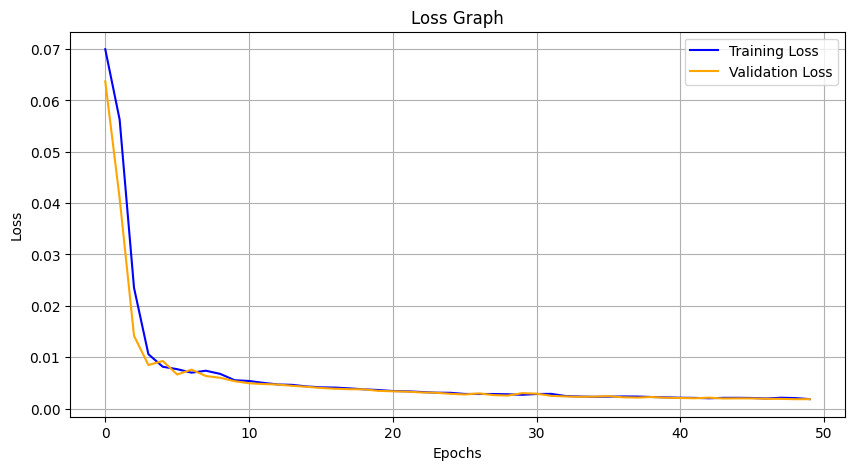

In [12]:
# --- Plot Loss Graph ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


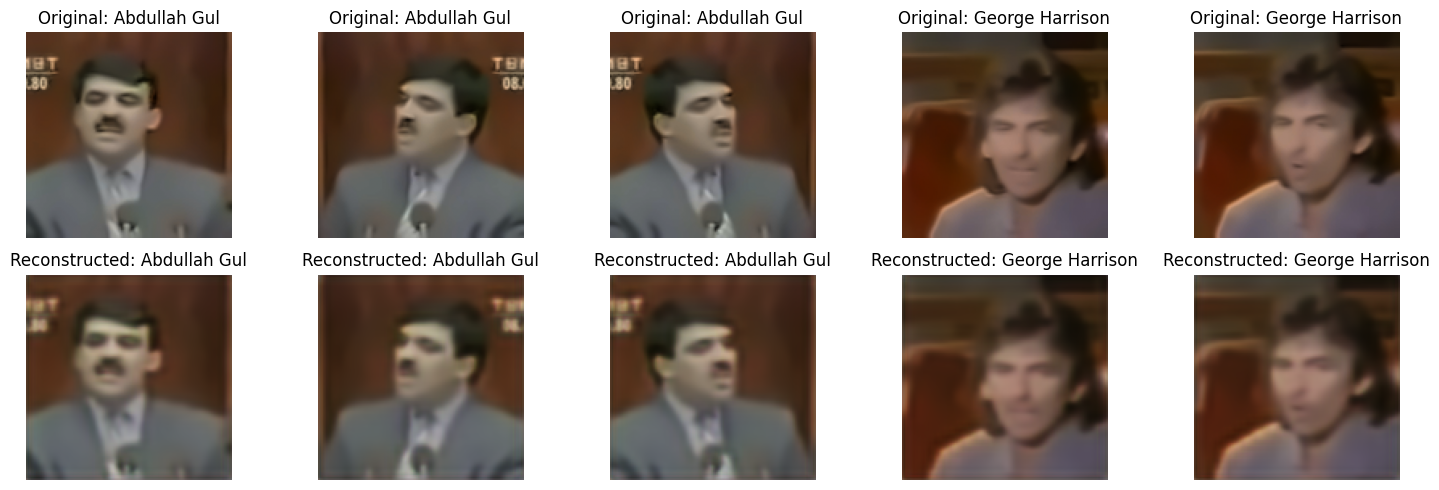

In [13]:
test_generator = DataGenerator(directory=dataset_dir, batch_size=8, file_sample_ratio=0.05, sample_ratio=0.05, img_size=(128, 128), shuffle=False, return_names=True)

# Test the generator to ensure it's working correctly and extract names for visualization
test_images, _, test_names = test_generator[0]  # First batch

# Generate enhanced images from the test set
reconstructed_images = autoencoder.predict(test_images[:5])  # Predicting on first 5 samples

# Display a comparison between original and enhanced images
display_comparison(test_images[:5], reconstructed_images, test_names, n=5)

In [14]:
# --- Create Predictions Table ---
predictions_df = pd.DataFrame({
    'Filename': test_generator.filenames[:5],
    'Original': [test_images[i] for i in range(5)],
    'Reconstructed': [reconstructed_images[i] for i in range(5)]
})

# Display predictions table
print(predictions_df)

          Filename                                           Original  \
0     Abdullah Gul  [[[0.3333333333333333, 0.19607843137254902, 0....   
1  George Harrison  [[[0.4627450980392157, 0.3058823529411765, 0.2...   
2     Fidel Castro  [[[0.3333333333333333, 0.19607843137254902, 0....   
3      Talisa Soto  [[[0.28627450980392155, 0.2627450980392157, 0....   
4   Andrew Bernard  [[[0.2901960784313726, 0.2627450980392157, 0.2...   

                                       Reconstructed  
0  [[[0.3485127, 0.3368767, 0.2930863], [0.318771...  
1  [[[0.4017781, 0.39366928, 0.35195398], [0.3649...  
2  [[[0.34945077, 0.3377307, 0.2939164], [0.32003...  
3  [[[0.3513748, 0.37173614, 0.33502895], [0.3133...  
4  [[[0.35628965, 0.37772307, 0.34051785], [0.320...  


In [16]:
# --- Calculate Performance Metrics ---
mse = mean_squared_error(test_images[:5].reshape(-1, 128 * 128 * 3), reconstructed_images.reshape(-1, 128 * 128 * 3)) 
psnr_value = psnr(test_images[:5], reconstructed_images, data_range=1.0)

# --- Create Performance Metrics Table ---
metrics_df = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Peak Signal-to-Noise Ratio (PSNR)'],
    'Value': [mse, psnr_value]
})

# Display performance metrics table
print(metrics_df)

                              Metric      Value
0           Mean Squared Error (MSE)   0.000480
1  Peak Signal-to-Noise Ratio (PSNR)  33.188666


In [20]:
# Save the model after training
autoencoder.save("Facial-reconstruction-from-CCTV-footage/models/final_model.keras")

In [18]:
# Save comparisons for evaluation using person's name as filename
save_comparisons(test_images[:5], reconstructed_images, test_names)

In [4]:
# Extract biases from layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('models/final_model.keras')

biases = []
layer_names = []

for layer in model.layers:
    if hasattr(layer, 'bias'):
        print(f'Layer: {layer.name}, Bias: {layer.bias.numpy()}')

        biases.append(layer.bias.numpy().tolist())
        layer_names.append(layer.name) 


Layer: conv2d, Bias: [ 0.05969594  0.1301551   0.04537142  0.04124771  0.09847713  0.06511798
  0.04634646  0.03150934  0.04542617 -0.03083689  0.05162053 -0.01258408
  0.04754675  0.02423113  0.05385648 -0.02466999  0.05753806 -0.04781865
  0.0323956   0.00064246  0.05531832  0.01235494 -0.03455072  0.05237484
  0.04660605  0.00301667  0.0362032   0.05800354 -0.00378828  0.03738186
 -0.03726763 -0.0488042 ]
Layer: conv2d_1, Bias: [ 0.04904953 -0.01371751  0.0626278  -0.04667268  0.03501539  0.06100406
  0.05157208  0.03771735  0.01701315  0.05218036  0.04786702 -0.01884701
 -0.0423123   0.06043694 -0.00834383 -0.04628145]
Layer: conv2d_2, Bias: [-0.04139105 -0.02723197  0.03756186 -0.01299548 -0.00158749 -0.04876024
  0.05096343 -0.00598178  0.06231652  0.05935585 -0.01637647  0.06817437
  0.01214335  0.10693479 -0.04852344  0.04854318]
Layer: conv2d_3, Bias: [ 0.05214112  0.04762048  0.05630839 -0.04773054 -0.06118881  0.00274121
 -0.03739752  0.05230516  0.05906283  0.01993635  0.00

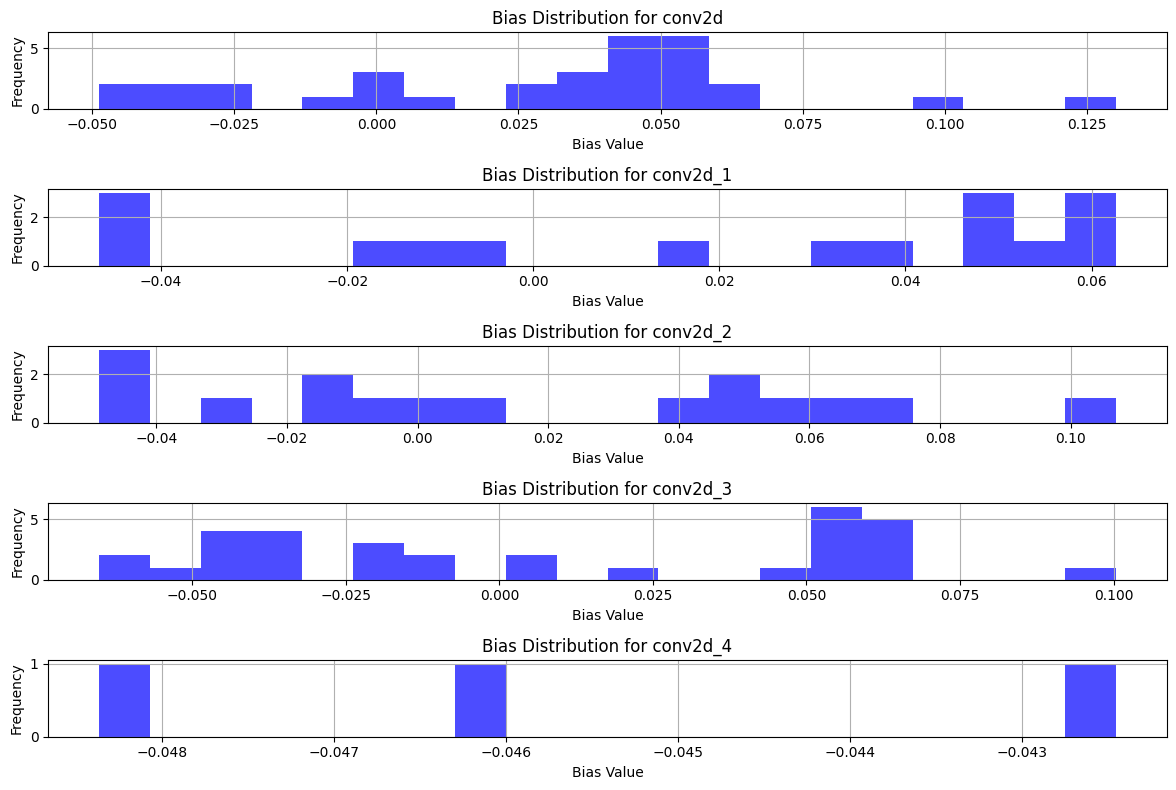

In [5]:
# Plotting histograms for each layer's bias values
plt.figure(figsize=(12, 8))
for i, (name, bias) in enumerate(zip(layer_names, biases)):
    plt.subplot(len(biases), 1, i + 1)
    plt.hist(bias, bins=20, alpha=0.7, color='blue')
    plt.title(f'Bias Distribution for {name}')
    plt.xlabel('Bias Value')
    plt.ylabel('Frequency')
    plt.grid()

plt.tight_layout()
plt.show()